In [1]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import pythainlp as pythai

## ชุดข้อมูล
https://github.com/PyThaiNLP/thai-sentiment-analysis-dataset

In [2]:
data = pd.read_csv('./datasets/review_shopping.csv', sep='\t', encoding='utf-8', header=None)
data = data.append(pd.read_csv('./datasets/general-amy.csv', sep='\t', encoding='utf-8', header=None))
data = data.append(pd.read_csv('./datasets/tcas61.csv', sep='\t', encoding='utf-8', header=None))
data.columns = ['review', 'label']
data.head()

,review,label
0,เกลียด ชอบหลอกให้สั่งซื้อ ที่ไหนได้ไม่มีสิ้นค้า,neg
1,สินค้าด้อยคุณภาพ,neg
2,สินค้าหมดทำไมไม่แจ้งขึ้นว่าหมดอะ.กดใส่ตะกร้าไป...,neg
3,อย่าทำแบบนี้กับใครอีกนะค่ะแย่มากค่ะ,neg
4,คือเเบบผิดหวังมาก เเย่ที่สุดได้ของมาฝาเเตก เเต...,neg


### Tokenize

In [3]:
# Read data
data = pd.read_csv('./datasets/review_shopping.csv', sep='\t', encoding='utf-8', header=None)
data = data.append(pd.read_csv('./datasets/general-amy.csv', sep='\t', encoding='utf-8', header=None))
data = data.append(pd.read_csv('./datasets/tcas61.csv', sep='\t', encoding='utf-8', header=None))
data.columns = ['review', 'label']
# drop null
data = data.dropna()
# tokenize
data['review'] = data['review'].apply(lambda x: pythai.word_tokenize(x, engine='newmm'))
data['label'] = data['label'].map({'pos': 1, 'neg': 0})
data.head()

,review,label
0,"[เกลียด, , ชอบ, หลอก, ให้, สั่งซื้อ, , ที่ไห...",0
1,"[สินค้า, ด้อย, คุณภาพ]",0
2,"[สินค้า, หมด, ทำไม, ไม่, แจ้ง, ขึ้น, ว่า, หมด,...",0
3,"[อย่า, ทำ, แบบนี้, กับ, ใคร, อีก, นะ, ค่ะ, แย่...",0
4,"[คือ, เเบบ, ผิดหวัง, มาก, , เเย่, ที่สุด, ได้...",0


In [4]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(data['review'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(data['review'])
padded = pad_sequences(sequences, maxlen=60, padding='post', truncating='post')
print('Sample:', padded[20])

Sample: [ 32 163  93 157  62  13   5  13   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [5]:
# sample
test = padded[20]
# to text
tokenizer.sequences_to_texts([test])

['ใช้ เดือน เดียว พัง แย่ ๆ มาก ๆ <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>']

In [6]:
print(data.shape[0])
# train data
train_data = padded[:242]
train_label = data['label'][:242]
# test data
test_data = padded[242:]
test_label = data['label'][242:]
full = False
if full:
    train_data = padded
    train_label = data['label']
# train data, test data
print('Train data:', train_data.shape)
print('Test data:', test_data.shape)

341
Train data: (242, 60)
Test data: (99, 60)


In [7]:
# create simple model
model = keras.Sequential([
    keras.layers.Embedding(10000, 16, input_length=60),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 16)            160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [9]:
# train model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# early stop
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
# train
model.fit(train_data, train_label, epochs=100, validation_data=(test_data, test_label), callbacks=[early_stop])

Epoch 1/100
8/8 [==============================] - 5s 71ms/step - loss: 0.6935 - accuracy: 0.4752 - val_loss: 0.6940 - val_accuracy: 0.4343
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.6924 - accuracy: 0.5248 - val_loss: 0.6919 - val_accuracy: 0.6566
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.6914 - accuracy: 0.6570 - val_loss: 0.6896 - val_accuracy: 0.6667
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.6904 - accuracy: 0.5248 - val_loss: 0.6876 - val_accuracy: 0.6667
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.6896 - accuracy: 0.5248 - val_loss: 0.6858 - val_accuracy: 0.6667
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.6885 - accuracy: 0.5248 - val_loss: 0.6846 - val_accuracy: 0.6667
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.6872 - accuracy: 0.5248 - val_loss: 0.6829 - val_accuracy: 0.6667
Epoch 8/100
8/8 [===

### Evaluate


Bad key "text.kerning_factor" on line 4 in
c:\Users\hirun\.conda\envs\tensorflow-env37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


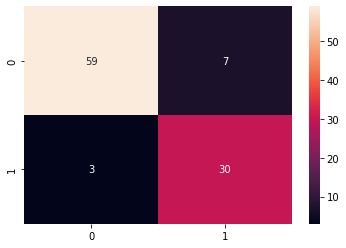

              precision    recall  f1-score   support

           0       0.95      0.89      0.92        66
           1       0.81      0.91      0.86        33

    accuracy                           0.90        99
   macro avg       0.88      0.90      0.89        99
weighted avg       0.90      0.90      0.90        99



In [10]:
# evaluate report
from sklearn.metrics import classification_report
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(test_data)
y_pred = np.round(y_pred)
cm = confusion_matrix(test_label, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()
print(classification_report(test_label, y_pred))

# save model

In [11]:
# save model
model.save('./weight/model.h5')

In [12]:
# load weight
model = keras.models.load_model('./weight/model.h5')
# save tokenizer
import pickle
with open('./weight/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# evaluate
model.evaluate(test_data, test_label)

4/4 [==============================] - 0s 6ms/step - loss: 0.2959 - accuracy: 0.8990


[0.29592427611351013, 0.8989899158477783]

In [13]:
def predict(text, decode=False):
    text = pythai.word_tokenize(text, engine='newmm')
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=60, padding='post', truncating='post')
    predict = model.predict(text)
    rounded = np.round(predict)
    if decode:
        return 'pos' if rounded == 1 else 'neg'
    return rounded

In [14]:
# predict
pred = predict('หาดีไม่ได้เลยร้านนี้อะ', decode=True)
pred

'neg'